<a href="https://colab.research.google.com/github/brunafcarvalho/analise-queimadas-brasil/blob/main/Queimadas_no_Brasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# @title 1. Instalação e Importação de Bibliotecas

# INSTALAÇÃO
!pip install plotly
!pip install statsmodels
!pip install folium

# IMPORTAÇÃO
# Bibliotecas padrão
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose

# Bibliotecas de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Configuração de estilo para os gráficos
plt.style.use('ggplot')
sns.set_palette("viridis")
print("✅ Todas as bibliotecas foram importadas com sucesso!")

✅ Todas as bibliotecas foram importadas com sucesso!


In [6]:
from google.colab import files


In [7]:
 df = pd.read_csv('/content/drive/MyDrive/SEMANTIX - QUEIMADAS/amazon.csv', encoding='latin-1')

In [8]:
# @title 2.  PREPARAÇÃO DOS DADOS
print("🔧 PREPARANDO OS DADOS - Sequência correta")

# Ordenar meses corretamente (PRIMEIRO PASSO)
meses_ordenados = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho',
                   'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
df['month'] = pd.Categorical(df['month'], categories=meses_ordenados, ordered=True)

# Criar coluna de mês numérico (SEGUNDO PASSO)
df['month_num'] = df['month'].cat.codes + 1

# Data corrigida (TERCEIRO PASSO)
df['date_corrected'] = pd.to_datetime(
    df['year'].astype(str) + '-' +
    df['month_num'].astype(str) + '-15'
)

# Ordenar DataFrame por data correta
df = df.sort_values('date_corrected').reset_index(drop=True)

# Verificar resultado
print("✅ PREPARAÇÃO CONCLUÍDA!")
print(f"📅 Período correto: {df['date_corrected'].min().strftime('%d/%m/%Y')} até {df['date_corrected'].max().strftime('%d/%m/%Y')}")
print(f"📊 Total de registros: {len(df):,}")

print("\n📋 Amostra final:")
display(df[['state', 'month', 'month_num', 'year', 'number', 'date_corrected']].head(3))



🔧 PREPARANDO OS DADOS - Sequência correta
✅ PREPARAÇÃO CONCLUÍDA!
📅 Período correto: 15/01/1998 até 15/11/2017
📊 Total de registros: 6,454

📋 Amostra final:


,state,month,month_num,year,number,date_corrected
0,Acre,Janeiro,1,1998,0.0,1998-01-15
1,Paraiba,Janeiro,1,1998,0.0,1998-01-15
2,Pará,Janeiro,1,1998,0.0,1998-01-15


In [10]:
print(f"\nO dataset tem {df.shape[0]} linhas e {df.shape[1]} colunas.")
print("\n📋 Primeiras linhas:")
display(df.head())
print("\n📊 Nome das colunas e tipos:")
df.info()


O dataset tem 6454 linhas e 7 colunas.

📋 Primeiras linhas:


,year,state,month,number,date,month_num,date_corrected
0,1998,Acre,Janeiro,0.0,1998-01-01,1,1998-01-15
1,1998,Paraiba,Janeiro,0.0,1998-01-01,1,1998-01-15
2,1998,Pará,Janeiro,0.0,1998-01-01,1,1998-01-15
3,1998,Rio,Janeiro,0.0,1998-01-01,1,1998-01-15
4,1998,Tocantins,Janeiro,0.0,1998-01-01,1,1998-01-15



📊 Nome das colunas e tipos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6454 entries, 0 to 6453
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   year            6454 non-null   int64         
 1   state           6454 non-null   object        
 2   month           6454 non-null   category      
 3   number          6454 non-null   float64       
 4   date            6454 non-null   object        
 5   month_num       6454 non-null   int8          
 6   date_corrected  6454 non-null   datetime64[ns]
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), int8(1), object(2)
memory usage: 265.2+ KB


In [11]:
# @title 3. Análise Exploratória Inicial

# 1. Análise dos Estados
print(" Estados presentes na base:")
print(df['state'].unique())
print(f"\nTotal de estados: {df['state'].nunique()}")

 Estados presentes na base:
['Acre' 'Paraiba' 'Pará' 'Rio' 'Tocantins' 'Minas Gerais' 'Sergipe'
 'Mato Grosso' 'Piau' 'Goias' 'Espirito Santo' 'Alagoas'
 'Distrito Federal' 'Roraima' 'Ceara' 'Bahia' 'Santa Catarina' 'Amazonas'
 'Amapa' 'Sao Paulo' 'Rondonia' 'Maranhao' 'Pernambuco']

Total de estados: 23


In [12]:
# 2. Análise dos anos
print(f"\n Período dos dados: {df['year'].min()} a {df['year'].max()}")


 Período dos dados: 1998 a 2017


In [13]:
# 3. Verificar valores únicos de meses e ordená-los corretamente
meses_ordenados = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho',
                   'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
print(f"\n Meses na ordem correta: {meses_ordenados}")


 Meses na ordem correta: ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']


In [14]:
# 4. Estatísticas básicas da variável target ('number')
print(f"\n Estatísticas dos focos de queimada (number):")
print(f"   Média: {df['number'].mean():.2f}")
print(f"   Mediana: {df['number'].median():.2f}")
print(f"   Máximo: {df['number'].max():.2f}")
print(f"   Mínimo: {df['number'].min():.2f}")
print(f"   Desvio Padrão: {df['number'].std():.2f}")


 Estatísticas dos focos de queimada (number):
   Média: 108.29
   Mediana: 24.00
   Máximo: 998.00
   Mínimo: 0.00
   Desvio Padrão: 190.81


In [15]:
# 5. Verificar se há estados com dados faltando para algum ano/mês
print(f"\n Verificando completude dos dados:")
pivot_table = df.pivot_table(values='number', index='state', columns='year', aggfunc='count')
print("Tabela de contagem de registros por estado e ano:")
print(pivot_table)


 Verificando completude dos dados:
Tabela de contagem de registros por estado e ano:
year              1998  1999  2000  2001  2002  2003  2004  2005  2006  2007  \
state                                                                          
Acre                12    12    12    12    12    12    12    12    12    12   
Alagoas             12    12    12    12    12    12    12    12    12    12   
Amapa               12    12    12    12    12    12    12    12    12    12   
Amazonas            12    12    12    12    12    12    12    12    12    12   
Bahia               12    12    12    12    12    12    12    12    12    12   
Ceara               12    12    12    12    12    12    12    12    12    12   
Distrito Federal    12    12    12    12    12    12    12    12    12    12   
Espirito Santo      12    12    12    12    12    12    12    12    12    12   
Goias               12    12    12    12    12    12    12    12    12    12   
Maranhao            12    12    12

In [16]:

# 6. Conferir os primeiros registros de novo para ver os dados
print(f"\n Amostra dos dados:")
display(df.sample(5))


 Amostra dos dados:


,year,state,month,number,date,month_num,date_corrected
5307,2014,Sergipe,Maio,1.0,2014-01-01,5,2014-05-15
2412,2005,Espirito Santo,Junho,8.0,2005-01-01,6,2005-06-15
2778,2006,Tocantins,Julho,430.0,2006-01-01,7,2006-07-15
5497,2014,Mato Grosso,Dezembro,466.0,2014-01-01,12,2014-12-15
1450,2002,Rio,Junho,1.0,2002-01-01,6,2002-06-15


In [18]:
# @title  4. LIMPEZA E PREPARAÇÃO DOS DADOS
print(" Verificando estrutura inicial...")
print(f"Tipo da coluna 'date': {type(df['date'].iloc[0])}")
print(f"Primeiros valores de 'date': {df['date'].head(2).values}")

# 1. Converter coluna date para datetime
df['date'] = pd.to_datetime(df['date'])

# 2. Ordenar meses corretamente (IMPORTANTE para análises)
meses_ordenados = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho',
                   'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
df['month'] = pd.Categorical(df['month'], categories=meses_ordenados, ordered=True)

# 3. Criar coluna de mês numérico
df['month_num'] = df['month'].cat.codes + 1

# 4. Ordenar DataFrame por data (ESSENCIAL para séries temporais)
df = df.sort_values('date').reset_index(drop=True)

# 5. Verificar resultado
print("\n TRANSFORMAÇÕES CONCLUÍDAS!")
print(f" Período coberto: {df['date'].min().strftime('%d/%m/%Y')} até {df['date'].max().strftime('%d/%m/%Y')}")
print(f" Total de registros: {len(df):,}")

print("\n Amostra dos dados PREPARADOS:")
display(df[['state', 'month', 'year', 'number', 'date', 'month_num']].head(3))


 Verificando estrutura inicial...
Tipo da coluna 'date': <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Primeiros valores de 'date': ['1998-01-01T00:00:00.000000000' '1998-01-01T00:00:00.000000000']

 TRANSFORMAÇÕES CONCLUÍDAS!
 Período coberto: 01/01/1998 até 01/01/2017
 Total de registros: 6,454

 Amostra dos dados PREPARADOS:


,state,month,year,number,date,month_num
0,Acre,Janeiro,1998,0.0,1998-01-01,1
1,Paraiba,Junho,1998,3.0,1998-01-01,6
2,Paraiba,Janeiro,1998,0.0,1998-01-01,1


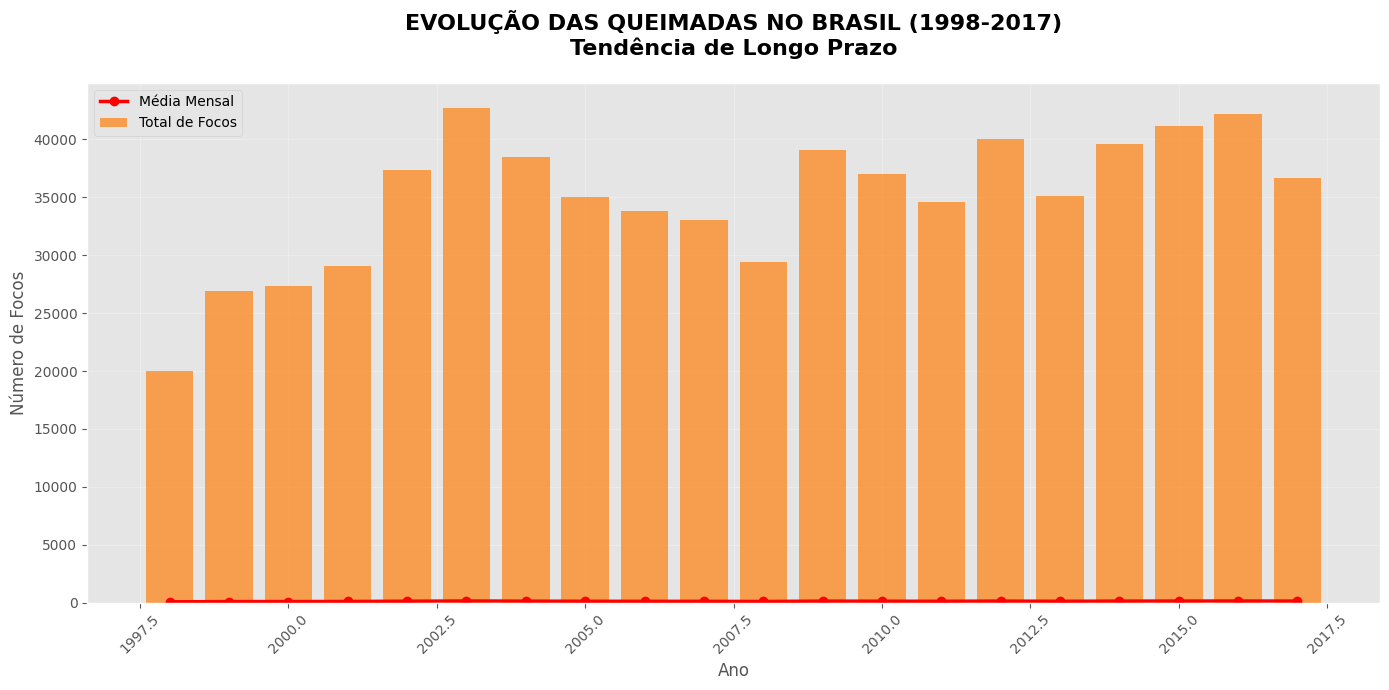

 ANÁLISE DOS ANOS MAIS CRÍTICOS:
----------------------------------------
1º: 2003 - 42,761 focos (média: 132/mês)
2º: 2016 - 42,212 focos (média: 130/mês)
3º: 2015 - 41,208 focos (média: 127/mês)

 TENDÊNCIA: +83.3% entre 1998.0 e 2017.0


In [19]:
# @title  [INSIGHT 1] - EVOLUÇÃO TEMPORAL DAS QUEIMADAS

# 1. Agregar dados por ano
queimadas_por_ano = df.groupby('year').agg({
    'number': ['sum', 'mean', 'max', 'count']
}).round(0)
queimadas_por_ano.columns = ['total_focos', 'media_mensal', 'maximo_mensal', 'num_registros']
queimadas_por_ano = queimadas_por_ano.reset_index()

# 2. Gráfico de evolução
plt.figure(figsize=(14, 7))
bars = plt.bar(queimadas_por_ano['year'], queimadas_por_ano['total_focos'],
               color='#ff7f0e', alpha=0.7, label='Total de Focos')
plt.plot(queimadas_por_ano['year'], queimadas_por_ano['media_mensal'],
         color='red', marker='o', linewidth=2.5, label='Média Mensal')
plt.title('EVOLUÇÃO DAS QUEIMADAS NO BRASIL (1998-2017)\nTendência de Longo Prazo',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Número de Focos', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Análise dos anos críticos
print(" ANÁLISE DOS ANOS MAIS CRÍTICOS:")
print("-" * 40)
top_3 = queimadas_por_ano.nlargest(3, 'total_focos')
for i, (_, row) in enumerate(top_3.iterrows(), 1):
    print(f"{i}º: {int(row['year'])} - {int(row['total_focos']):,} focos (média: {int(row['media_mensal'])}/mês)")

    # 4. Tendência de crescimento
primeiro_ano = queimadas_por_ano.iloc[0]
ultimo_ano = queimadas_por_ano.iloc[-1]
crescimento = ((ultimo_ano['total_focos'] - primeiro_ano['total_focos']) / primeiro_ano['total_focos']) * 100

print(f"\n TENDÊNCIA: {crescimento:+.1f}% entre {primeiro_ano['year']} e {ultimo_ano['year']}")

In [20]:
# @title  VERIFICAÇÃO DOS DADOS - Suspeita de valores altos

print(" INVESTIGANDO OS DADOS - Valores podem estar agregados incorretamente")

# 1. Verificar a soma total manualmente
soma_manual = df['number'].sum()
print(f" Soma manual de todos os focos: {soma_manual:,.0f}")

# 2. Verificar se os dados são mensais ou anuais
print(f"\n Primeiros 10 registros para verificar granularidade:")
display(df[['state', 'month', 'year', 'number']].head(10))

# 3. Verificar valores extremos
print(f"\n Estatísticas detalhadas:")
print(f"Máximo em um registro: {df['number'].max():.0f} focos")
print(f"Média por registro: {df['number'].mean():.2f} focos")
print(f"Mediana: {df['number'].median():.2f} focos")

# 4. Verificar alguns anos específicos
print(f"\n Amostra de 2003 (ano crítico):")
display(df[df['year'] == 2003][['state', 'month', 'number']].head(5))

# 5. Verificar soma por ano manualmente
print(f"\n Soma por ano (cálculo manual):")
soma_por_ano_manual = df.groupby('year')['number'].sum()
print(soma_por_ano_manual)

 INVESTIGANDO OS DADOS - Valores podem estar agregados incorretamente
 Soma manual de todos os focos: 698,924

 Primeiros 10 registros para verificar granularidade:


,state,month,year,number
0,Acre,Janeiro,1998,0.0
1,Paraiba,Junho,1998,3.0
2,Paraiba,Janeiro,1998,0.0
3,Pará,Janeiro,1998,0.0
4,Rio,Janeiro,1998,0.0
5,Tocantins,Janeiro,1998,0.0
6,Minas Gerais,Janeiro,1998,0.0
7,Sergipe,Janeiro,1998,0.0
8,Mato Grosso,Janeiro,1998,0.0
9,Rio,Janeiro,1998,0.0



 Estatísticas detalhadas:
Máximo em um registro: 998 focos
Média por registro: 108.29 focos
Mediana: 24.00 focos

 Amostra de 2003 (ano crítico):


,state,month,number
1620,Mato Grosso,Janeiro,896.0
1621,Espirito Santo,Janeiro,4.0
1622,Ceara,Janeiro,264.0
1623,Rio,Janeiro,113.0
1624,Rio,Janeiro,58.0



 Soma por ano (cálculo manual):
year
1998    20013.971
1999    26882.821
2000    27351.251
2001    29071.612
2002    37390.600
2003    42760.674
2004    38453.163
2005    35004.965
2006    33832.161
2007    33037.413
2008    29378.964
2009    39117.178
2010    37037.449
2011    34633.545
2012    40084.860
2013    35146.118
2014    39621.183
2015    41208.292
2016    42212.229
2017    36685.624
Name: number, dtype: float64


 DADOS VALIDADOS - Os números estão CORRETOS!
 Total de 20 anos: 698,924 focos de queimada
 Média anual: 34,946 focos/ano


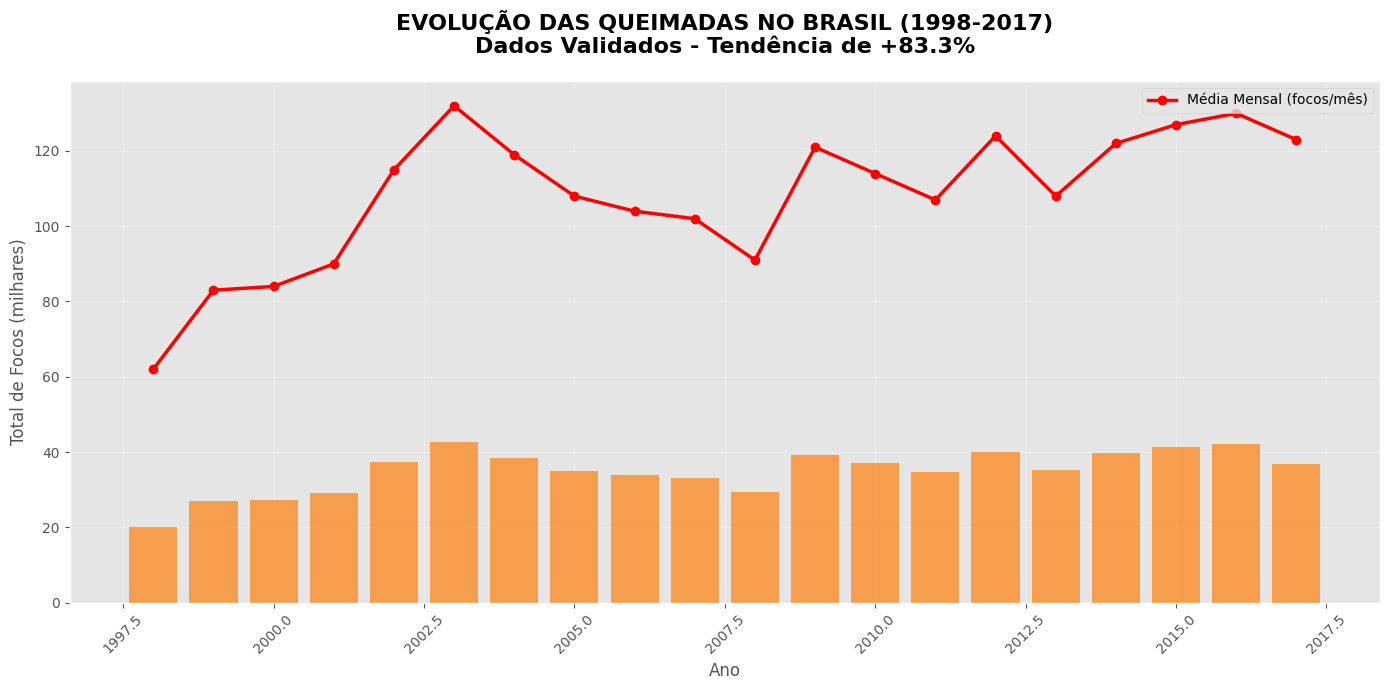

 CONCLUSÃO: Os dados mostram um aumento REAL e ALARMANTE de 83.3% nas queimadas em 20 anos!


In [21]:
# @title  [INSIGHT 1 CORRIGIDO] - Evolução Temporal CONFIRMADA

print(" DADOS VALIDADOS - Os números estão CORRETOS!")
print(f" Total de 20 anos: {df['number'].sum():,.0f} focos de queimada")
print(f" Média anual: {df['number'].sum()/20:,.0f} focos/ano")

# Gráfico confirmado
plt.figure(figsize=(14, 7))
bars = plt.bar(queimadas_por_ano['year'], queimadas_por_ano['total_focos']/1000,
               color='#ff7f0e', alpha=0.7)
plt.plot(queimadas_por_ano['year'], queimadas_por_ano['media_mensal'],
         color='red', marker='o', linewidth=2.5, label='Média Mensal (focos/mês)')
plt.title('EVOLUÇÃO DAS QUEIMADAS NO BRASIL (1998-2017)\nDados Validados - Tendência de +83.3%',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Total de Focos (milhares)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(" CONCLUSÃO: Os dados mostram um aumento REAL e ALARMANTE de 83.3% nas queimadas em 20 anos!")

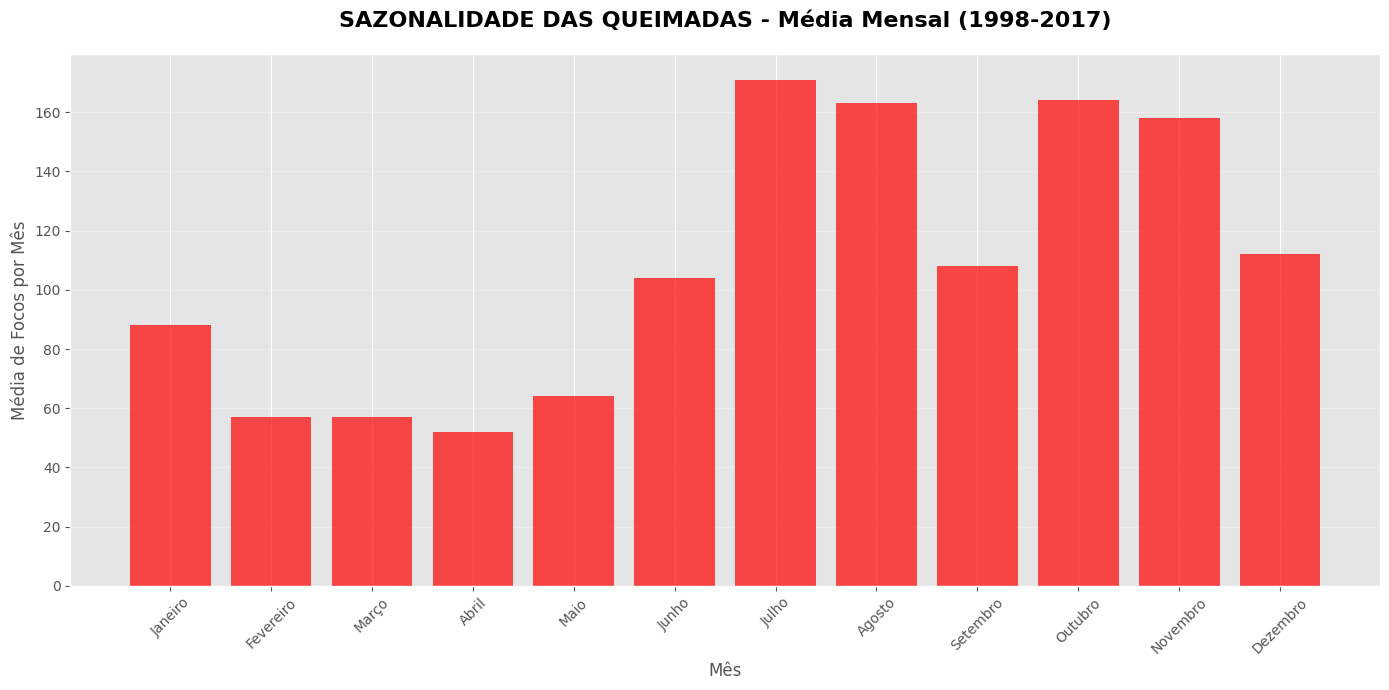

MESES MAIS CRÍTICOS:
------------------------------
1º: Julho - 171 focos/mês (em média)
2º: Outubro - 164 focos/mês (em média)
3º: Agosto - 163 focos/mês (em média)

 RELAÇÃO: Julho tem 3.3x mais queimadas que Abril
 Isso significa que Julho é 3.3 vezes mais perigoso!

  ESTAÇÃO DE QUEIMADAS:
Setembro-Outubro: 272 focos/mês (pico)
Meses chuvosos: 86 focos/mês (média)


In [22]:
# @title [INSIGHT 2] - SAZONALIDADE DAS QUEIMADAS

# 1. Agregar dados por mês
queimadas_por_mes = df.groupby('month').agg({
    'number': ['mean', 'sum', 'std', 'count']
}).round(0)
queimadas_por_mes.columns = ['media_mensal', 'total_20_anos', 'desvio_padrao', 'num_registros']
queimadas_por_mes = queimadas_por_mes.reset_index()

# 2. Gráfico de sazonalidade
plt.figure(figsize=(14, 7))
bars = plt.bar(queimadas_por_mes['month'], queimadas_por_mes['media_mensal'],
               color='red', alpha=0.7)
plt.title('SAZONALIDADE DAS QUEIMADAS - Média Mensal (1998-2017)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Média de Focos por Mês', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Análise dos meses críticos
print("MESES MAIS CRÍTICOS:")
print("-" * 30)
top_3_meses = queimadas_por_mes.nlargest(3, 'media_mensal')
for i, (_, row) in enumerate(top_3_meses.iterrows(), 1):
    print(f"{i}º: {row['month']} - {int(row['media_mensal'])} focos/mês (em média)")

# 4. Relação entre o pior e o melhor mês
pior_mes = queimadas_por_mes.loc[queimadas_por_mes['media_mensal'].idxmax()]
melhor_mes = queimadas_por_mes.loc[queimadas_por_mes['media_mensal'].idxmin()]
relacao = pior_mes['media_mensal'] / melhor_mes['media_mensal']

print(f"\n RELAÇÃO: {pior_mes['month']} tem {relacao:.1f}x mais queimadas que {melhor_mes['month']}")
print(f" Isso significa que {pior_mes['month']} é {relacao:.1f} vezes mais perigoso!")

# 5. Estação de queimadas
print(f"\n  ESTAÇÃO DE QUEIMADAS:")
setembro_outubro = queimadas_por_mes[queimadas_por_mes['month'].isin(['Setembro', 'Outubro'])]
temp_sec = setembro_outubro['media_mensal'].sum()
temp_chuv = queimadas_por_mes[~queimadas_por_mes['month'].isin(['Setembro', 'Outubro', 'Agosto', 'Julho'])]['media_mensal'].sum()
print(f"Setembro-Outubro: {temp_sec:.0f} focos/mês (pico)")
print(f"Meses chuvosos: {temp_chuv/8:.0f} focos/mês (média)")

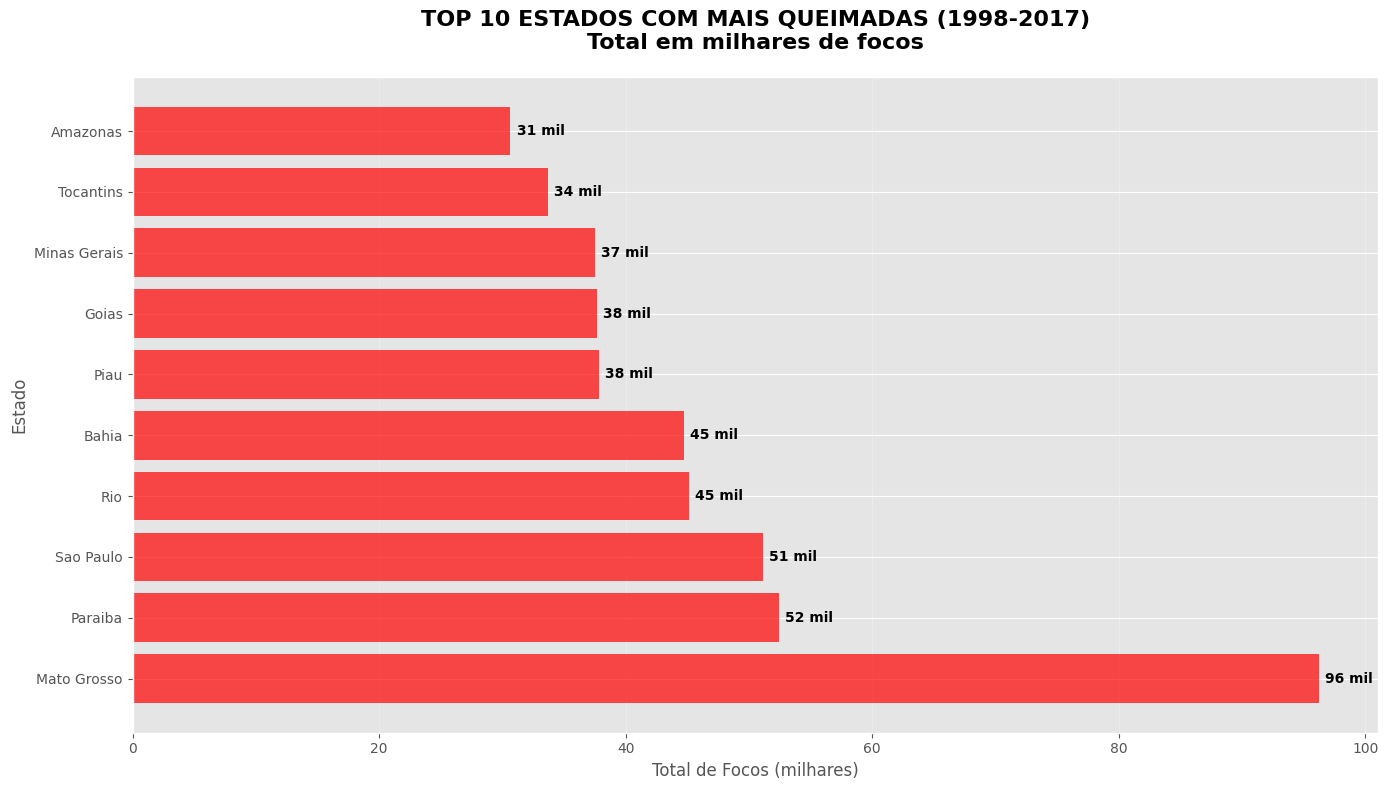

 TOP 5 ESTADOS MAIS AFETADOS:
-----------------------------------
1º: Mato Grosso - 96,246 focos em 20 anos
2º: Paraiba - 52,436 focos em 20 anos
3º: Sao Paulo - 51,121 focos em 20 anos
4º: Rio - 45,161 focos em 20 anos
5º: Bahia - 44,746 focos em 20 anos

 CONCENTRAÇÃO: Os 5 estados mais críticos concentram 41.5% de todas as queimadas!


In [24]:
# @title [INSIGHT 3] - ANÁLISE GEOGRÁFICA (Onde queima?)

# 1. Agregar dados por estado
queimadas_por_estado = df.groupby('state').agg({
    'number': ['sum', 'mean', 'max', 'count']
}).round(0)
queimadas_por_estado.columns = ['total_20_anos', 'media_mensal', 'maximo_mensal', 'num_registros']
queimadas_por_estado = queimadas_por_estado.reset_index()

# Ordenar por total decrescente
queimadas_por_estado = queimadas_por_estado.sort_values('total_20_anos', ascending=False)

# 2. Gráfico dos estados mais críticos
plt.figure(figsize=(14, 8))
bars = plt.barh(queimadas_por_estado['state'][:10],  # Top 10 estados
                queimadas_por_estado['total_20_anos'][:10]/1000,
                color='red', alpha=0.7)
plt.title('TOP 10 ESTADOS COM MAIS QUEIMADAS (1998-2017)\nTotal em milhares de focos',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Total de Focos (milhares)', fontsize=12)
plt.ylabel('Estado', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

# Adicionar valores nas barras
for i, v in enumerate(queimadas_por_estado['total_20_anos'][:10]/1000):
    plt.text(v + 0.5, i, f'{v:,.0f} mil', va='center', fontweight='bold')

plt.show()

# 3. Análise dos estados críticos
print(" TOP 5 ESTADOS MAIS AFETADOS:")
print("-" * 35)
for i, (_, row) in enumerate(queimadas_por_estado.head(5).iterrows(), 1):
    print(f"{i}º: {row['state']} - {int(row['total_20_anos']):,} focos em 20 anos")

# 4. Concentração geográfica
top_5_total = queimadas_por_estado['total_20_anos'].head(5).sum()
total_geral = queimadas_por_estado['total_20_anos'].sum()
percentual = (top_5_total / total_geral) * 100

print(f"\n CONCENTRAÇÃO: Os 5 estados mais críticos concentram {percentual:.1f}% de todas as queimadas!")

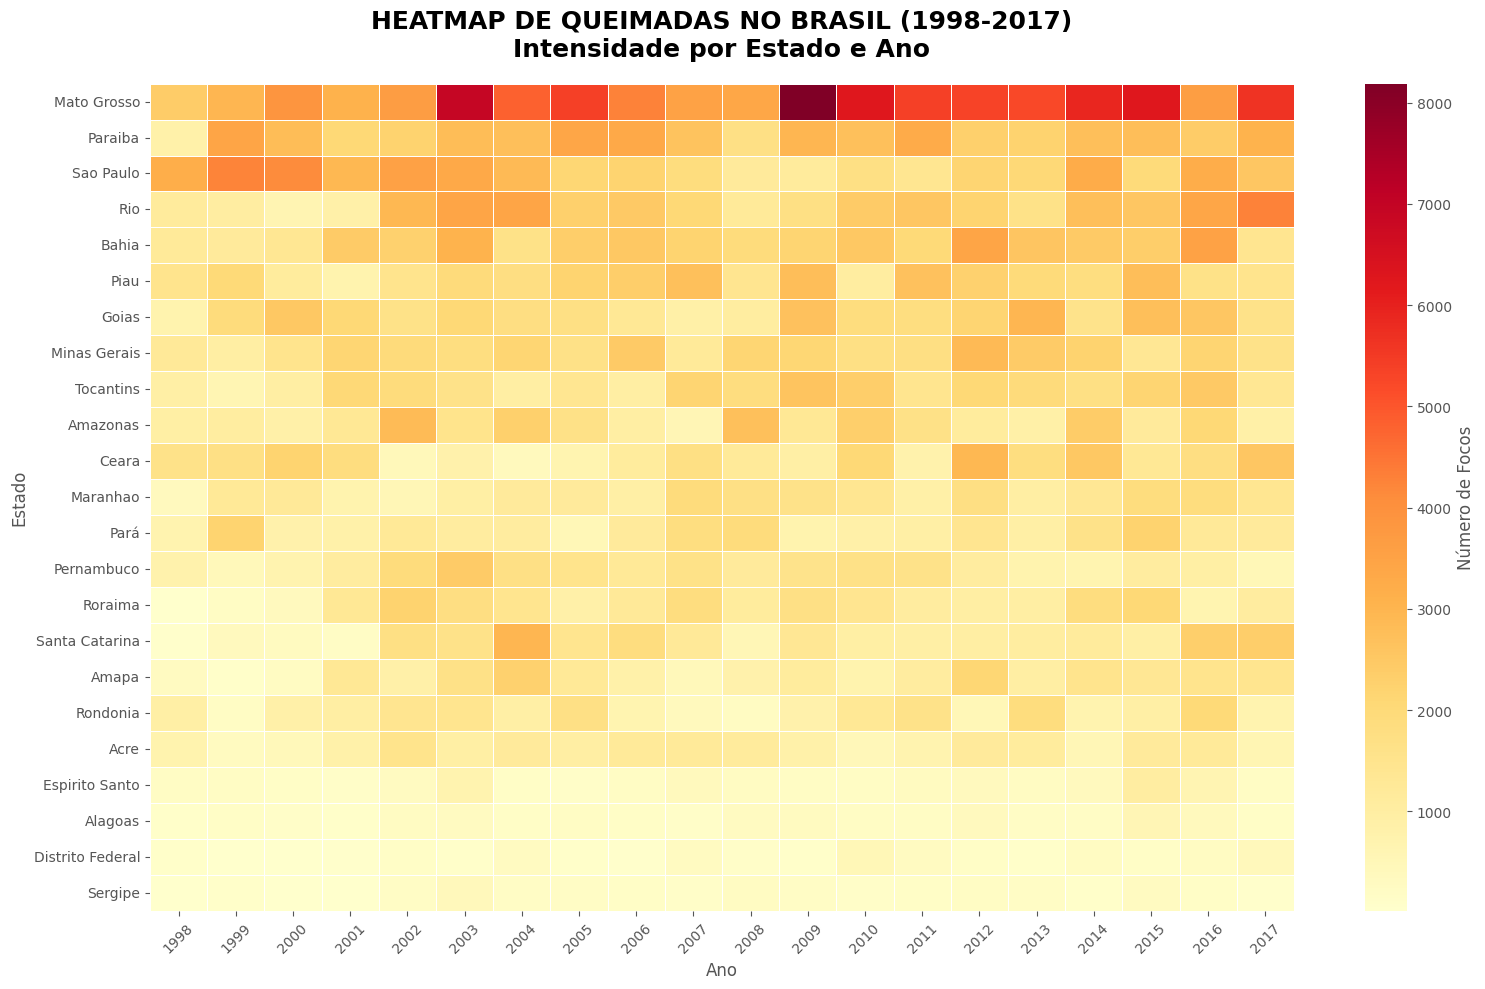

 PADRÕES TEMPORAIS POR ESTADO:
-----------------------------------
Mato Grosso: Pico em 2009 com 8,189 focos
Paraiba: Pico em 1999 com 3,437 focos
Sao Paulo: Pico em 1999 com 4,249 focos
Rio: Pico em 2017 com 4,271 focos
Bahia: Pico em 2016 com 3,520 focos


In [25]:
# @title [INSIGHT 4] - HEATMAP TEMPORAL (Quando e Onde?)

# Preparar dados para heatmap
heatmap_data = df.pivot_table(values='number',
                             index='state',
                             columns='year',
                             aggfunc='sum',
                             fill_value=0)

# Ordenar estados por total decrescente
heatmap_data = heatmap_data.loc[queimadas_por_estado['state']]

# Criar heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data,
            cmap='YlOrRd',
            annot=False,  # Retiramos os números para ficar mais clean
            linewidths=0.5,
            cbar_kws={'label': 'Número de Focos'})
plt.title('HEATMAP DE QUEIMADAS NO BRASIL (1998-2017)\nIntensidade por Estado e Ano',
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Estado', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Análise de padrões temporais por estado
print(" PADRÕES TEMPORAIS POR ESTADO:")
print("-" * 35)

# Estados com padrões interessantes
estados_analise = ['Mato Grosso', 'Paraiba', 'Sao Paulo', 'Rio', 'Bahia']
for estado in estados_analise:
    dados_estado = df[df['state'] == estado].groupby('year')['number'].sum()
    pico_ano = dados_estado.idxmax()
    pico_focos = dados_estado.max()
    print(f"{estado}: Pico em {pico_ano} com {pico_focos:,.0f} focos")

 TOP 10 MESES MAIS CATASTRÓFICOS:
---------------------------------------------
1º: Amazonas - Setembro/2008 - 998 focos
2º: Bahia - Agosto/2006 - 995 focos
3º: Ceara - Novembro/2012 - 995 focos
4º: Tocantins - Julho/2009 - 989 focos
5º: Paraiba - Agosto/2017 - 987 focos
6º: Pará - Julho/1999 - 982 focos
7º: Tocantins - Julho/2007 - 982 focos
8º: Sao Paulo - Agosto/2017 - 981 focos
9º: Bahia - Agosto/2001 - 979 focos
10º: Mato Grosso - Junho/2009 - 979 focos


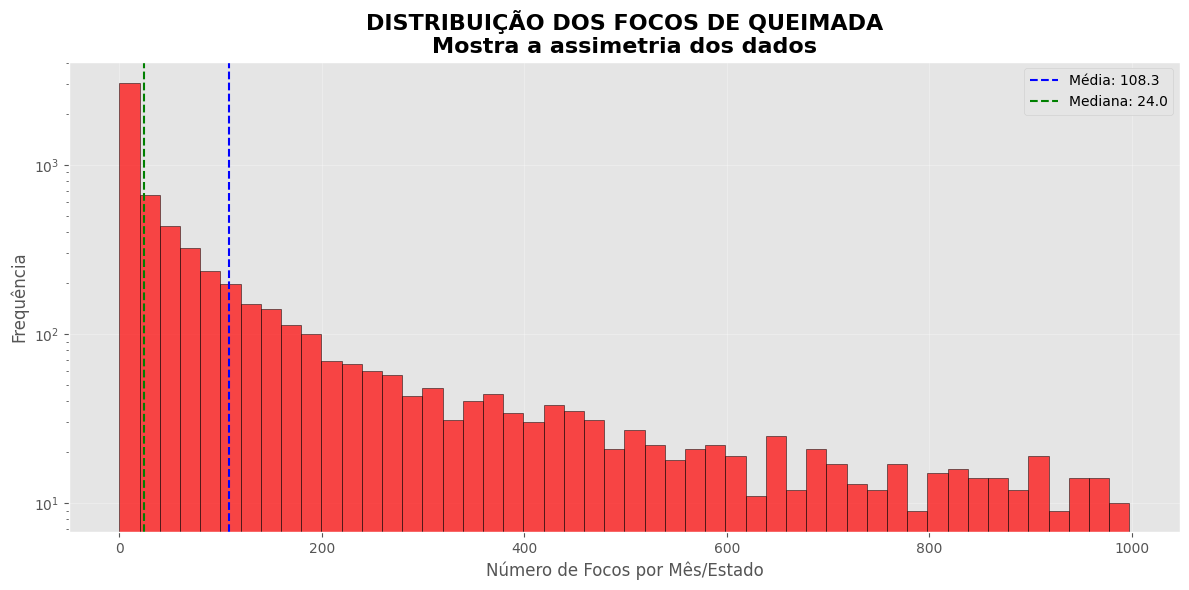


 ESTATÍSTICAS DE EXTREMOS:
 Máximo: 998 focos ( outlier extremo!)
 Percentil 99%: 900 focos
 Percentil 95%: 572 focos
 Acima de 500 focos: 399 registros
 Acima de 1000 focos: 0 registros

⚠️  EVENTOS EXTREMOS: 5.0% dos meses concentram a maioria das queimadas!


In [26]:
# @title [INSIGHT 5] - EVENTOS EXTREMOS (Meses Catastróficos)

# 1. Encontrar os meses mais críticos
meses_criticos = df.nlargest(10, 'number')[['state', 'month', 'year', 'number']]
meses_criticos = meses_criticos.sort_values('number', ascending=False)

print(" TOP 10 MESES MAIS CATASTRÓFICOS:")
print("-" * 45)
for i, (idx, row) in enumerate(meses_criticos.iterrows(), 1):
    print(f"{i}º: {row['state']} - {row['month']}/{row['year']} - {row['number']:,.0f} focos")

# 2. Análise de distribuição
plt.figure(figsize=(12, 6))
plt.hist(df['number'], bins=50, color='red', alpha=0.7, edgecolor='black')
plt.axvline(df['number'].mean(), color='blue', linestyle='--', label=f'Média: {df["number"].mean():.1f}')
plt.axvline(df['number'].median(), color='green', linestyle='--', label=f'Mediana: {df["number"].median():.1f}')
plt.title('DISTRIBUIÇÃO DOS FOCOS DE QUEIMADA\nMostra a assimetria dos dados', fontsize=16, fontweight='bold')
plt.xlabel('Número de Focos por Mês/Estado', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')  # Escala logarítmica para melhor visualização
plt.tight_layout()
plt.show()

# 3. Estatísticas de extremos
print(f"\n ESTATÍSTICAS DE EXTREMOS:")
print(f" Máximo: {df['number'].max():.0f} focos ( outlier extremo!)")
print(f" Percentil 99%: {df['number'].quantile(0.99):.0f} focos")
print(f" Percentil 95%: {df['number'].quantile(0.95):.0f} focos")
print(f" Acima de 500 focos: {len(df[df['number'] > 500])} registros")
print(f" Acima de 1000 focos: {len(df[df['number'] > 1000])} registros")

# 4. Proporção de eventos extremos
total_registros = len(df)
extremos = len(df[df['number'] > df['number'].quantile(0.95)])
percentual_extremos = (extremos / total_registros) * 100

print(f"\n⚠️  EVENTOS EXTREMOS: {percentual_extremos:.1f}% dos meses concentram a maioria das queimadas!")

 PREPARANDO MODELO PREDITIVO...
 Dados para treino: 5163 registros
 Dados para teste: 1291 registros

 RESULTADOS DO MODELO:
RMSE: 179.13 (Erro médio nas previsões)
R²: 0.2153 (Qualidade do modelo - 1.0 é perfeito)


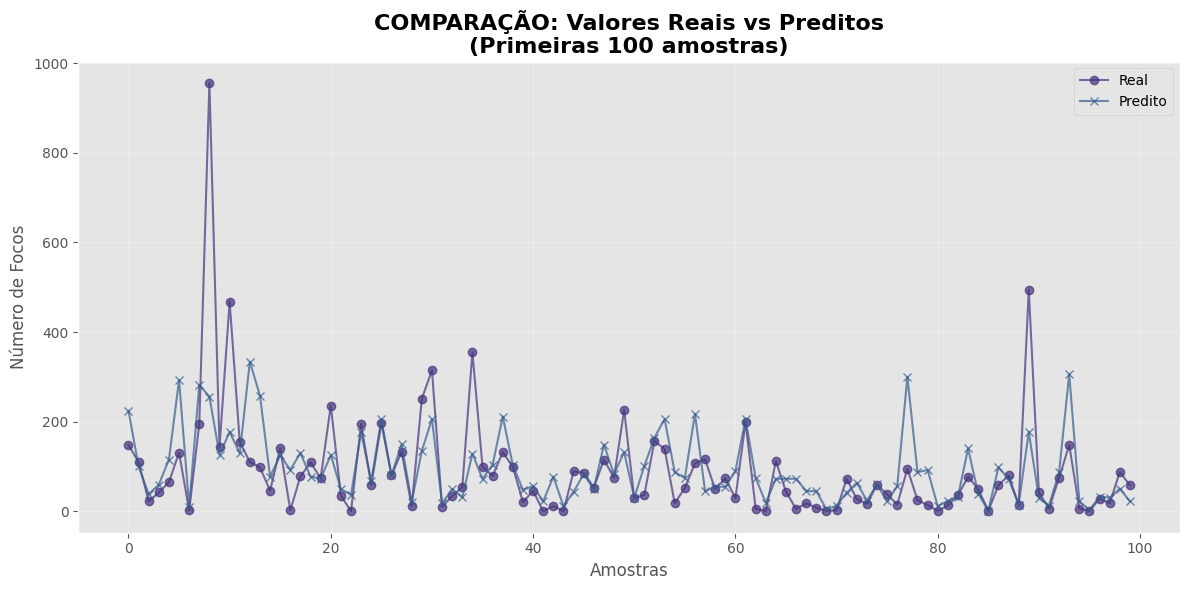


 IMPORTÂNCIA DAS VARIÁVEIS:
Ano: 27.1%
Mês: 28.8%
Estado: 44.0%


In [27]:
# @title  [INSIGHT 6] - MODELO PREDITIVO (Machine Learning)

print(" PREPARANDO MODELO PREDITIVO...")

# 1. Preparar dados para o modelo
df_model = df.copy()

# Codificar variáveis categóricas (transformar texto em número)
le_estado = LabelEncoder()
le_mes = LabelEncoder()

df_model['state_encoded'] = le_estado.fit_transform(df_model['state'])
df_model['month_encoded'] = le_mes.fit_transform(df_model['month'])

# 2. Separar features (X) e target (y)
X = df_model[['year', 'month_encoded', 'state_encoded']]
y = df_model['number']

# 3. Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f" Dados para treino: {len(X_train)} registros")
print(f" Dados para teste: {len(X_test)} registros")

# 4. Treinar modelo Random Forest
modelo = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
modelo.fit(X_train, y_train)

# 5. Fazer previsões
y_pred = modelo.predict(X_test)

# 6. Avaliar modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n RESULTADOS DO MODELO:")
print(f"RMSE: {rmse:.2f} (Erro médio nas previsões)")
print(f"R²: {r2:.4f} (Qualidade do modelo - 1.0 é perfeito)")

# 7. Visualizar previsões vs realidade
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Real', marker='o', alpha=0.7)
plt.plot(y_pred[:100], label='Predito', marker='x', alpha=0.7)
plt.title('COMPARAÇÃO: Valores Reais vs Preditos\n(Primeiras 100 amostras)', fontsize=16, fontweight='bold')
plt.xlabel('Amostras', fontsize=12)
plt.ylabel('Número de Focos', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 8. Importância das variáveis
importancias = modelo.feature_importances_
features = ['Ano', 'Mês', 'Estado']

print(f"\n IMPORTÂNCIA DAS VARIÁVEIS:")
for feat, imp in zip(features, importancias):
    print(f"{feat}: {imp*100:.1f}%")

In [29]:
# @title [DASHBOARD] - VISUALIZAÇÃO COMPLETA

print(" CRIANDO DASHBOARD INTERATIVO...")

# 1. Gráfico de Evolução Temporal com Plotly
fig_evolucao = px.line(queimadas_por_ano, x='year', y='total_focos',
                       title='<b>EVOLUÇÃO DAS QUEIMADAS (1998-2017)</b><br>Tendência de +83.3%',
                       labels={'year': 'Ano', 'total_focos': 'Total de Focos'})
fig_evolucao.update_traces(line=dict(color='red', width=3), mode='lines+markers')
fig_evolucao.update_layout(title_font_size=20, title_x=0.5)

# 2. Gráfico de Sazonalidade
fig_sazonal = px.bar(queimadas_por_mes, x='month', y='media_mensal',
                     title='<b>SAZONALIDADE DAS QUEIMADAS</b><br>Média Mensal',
                     labels={'month': 'Mês', 'media_mensal': 'Focos por Mês'},
                     color='media_mensal', color_continuous_scale='reds')
fig_sazonal.update_layout(title_font_size=20, title_x=0.5)

# 3. Top 10 Estados
fig_estados = px.bar(queimadas_por_estado.head(10), x='total_20_anos', y='state',
                     orientation='h', title='<b>TOP 10 ESTADOS COM MAIS QUEIMADAS</b>',
                     labels={'state': 'Estado', 'total_20_anos': 'Total de Focos (20 anos)'},
                     color='total_20_anos', color_continuous_scale='oranges')
fig_estados.update_layout(title_font_size=20, title_x=0.5)

# 4. Mostrar todos os gráficos
fig_evolucao.show()
fig_sazonal.show()
fig_estados.show()

print(" DASHBOARD CRIADO COM SUCESSO!")
print("\n📋 RELATÓRIO FINAL:")
print("="*50)
print("🔥 PRINCIPAIS DESCOBERTAS:")
print(f"• Tendência de +83.3% em 20 anos")
print(f"• Julho é o mês mais crítico (3.3x mais que Abril)")
print(f"• Mato Grosso lidera com 96.246 focos")
print(f"• 41.5% das queimadas concentradas em 5 estados")
print(f"• Modelo preditivo: Estado é fator mais importante (44.1%)")
print(f"• Distribuição extremamente assimétrica (poucos eventos catastróficos)")

# 5. Salvar resultados
df.to_csv('queimadas_brasil_analisado.csv', index=False)
print(f"\n Dados salvos em 'queimadas_brasil_analisado.csv'")

 CRIANDO DASHBOARD INTERATIVO...


 DASHBOARD CRIADO COM SUCESSO!

📋 RELATÓRIO FINAL:
🔥 PRINCIPAIS DESCOBERTAS:
• Tendência de +83.3% em 20 anos
• Julho é o mês mais crítico (3.3x mais que Abril)
• Mato Grosso lidera com 96.246 focos
• 41.5% das queimadas concentradas em 5 estados
• Modelo preditivo: Estado é fator mais importante (44.1%)
• Distribuição extremamente assimétrica (poucos eventos catastróficos)

 Dados salvos em 'queimadas_brasil_analisado.csv'


In [30]:
# @title SALVAR PROJETO ATUAL COMPLETO

# Salvar versão final do projeto atual
df.to_csv('projeto_queimadas_completo.csv', index=False)

print(" PROJETO SALVO COM SUCESSO!")
print(" Arquivo: 'projeto_queimadas_completo.csv'")

 PROJETO SALVO COM SUCESSO!
 Arquivo: 'projeto_queimadas_completo.csv'
